In [2]:
# =========================
# 0) PATHS + IMPORTS
# =========================
import sys
from pathlib import Path

PROJECT_ROOT = Path(r"c:\Users\asus\OneDrive\EV-projects\evcs-projects")
sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT / "src"))
sys.path.insert(0, str(PROJECT_ROOT / "scripts"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import value

from destruction_reconstruction import run_one_policy_multi, run_DR_multi
from scripts.randomInstance import load_instance, generate_instance, save_instance

plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25


# =========================
# 1) CLEAN HELPERS
# =========================
def covered_by_period(m, inst, y_thr=0.5):
    demand_IT = inst["demand_IT"]
    T = len(demand_IT)
    I = range(len(inst["coords_I"]))

    cov = []
    for t in range(T):
        covered_t = 0.0
        for i in I:
            assigned = 0.0
            for (ii, j) in m.Arcs:
                if int(ii) != int(i):
                    continue
                try:
                    assigned = max(assigned, float(value(m.y[ii, j, t])))
                except Exception:
                    pass
                if assigned >= y_thr:
                    break
            if assigned >= y_thr:
                covered_t += float(demand_IT[t][i])
        cov.append(float(covered_t))
    return cov



def chargers_by_period(m, inst):
    """Return x_sum[t] = sum_j x[j,t] (installed chargers available in period t)."""
    T = len(inst["demand_IT"])
    N = len(inst["coords_J"])
    xs = []
    for t in range(T):
        s = 0.0
        for j in range(N):
            try:
                s += float(value(m.x[j, t]))
            except Exception:
                pass
        xs.append(float(s))
    return xs


def plot_solution_geometry_multi(
    inst, m, t: int,
    title: str = "",
    show_edges: bool = False,
    max_edges: int = 400,
    y_thr: float = 0.5,
):
    coords_I = np.asarray(inst["coords_I"])
    coords_J = np.asarray(inst["coords_J"])
    a_t = np.asarray(inst["demand_IT"][t], dtype=float)

    # read installed chargers x[j,t]
    xjt = np.zeros(coords_J.shape[0], dtype=float)
    for j in range(coords_J.shape[0]):
        try:
            xjt[j] = float(value(m.x[j, t]))
        except Exception:
            xjt[j] = 0.0

    # marker sizes for demand
    a_pos = np.maximum(a_t, 0.0)
    sI = 25 + 220 * (a_pos / a_pos.max()) if a_pos.max() > 0 else np.full_like(a_pos, 60.0)

    fig, ax = plt.subplots(figsize=(7.8, 6.8))

    # Demand points
    ax.scatter(coords_I[:, 0], coords_I[:, 1], s=sI, alpha=0.75, label=f"Demand nodes (t={t})")

    # Candidate sites
    ax.scatter(coords_J[:, 0], coords_J[:, 1], s=14, alpha=0.18, label="Candidate sites")

    # Installed chargers overlay
    open_mask = xjt > 1e-9
    if open_mask.any():
        x_open = xjt[open_mask]
        sJ = 70 + 320 * (x_open / max(1.0, x_open.max()))
        ax.scatter(coords_J[open_mask, 0], coords_J[open_mask, 1],
                   s=sJ, alpha=0.95, label="Installed (size ∝ chargers)")

    # Optional edges (only if y is binary; we use y_thr=0.5 by default)
    if show_edges and hasattr(m, "y"):
        edges = []
        for (i, j) in list(m.Arcs):
            try:
                yv = float(value(m.y[i, j, t]))
            except Exception:
                continue
            if yv >= y_thr:
                edges.append((int(i), int(j)))

        if len(edges) > max_edges:
            edges = edges[:max_edges]

        for (i, j) in edges:
            ax.plot([coords_I[i, 0], coords_J[j, 0]],
                    [coords_I[i, 1], coords_J[j, 1]],
                    linewidth=0.6, alpha=0.10)

    ax.set_title(title if title else f"Geometry t={t}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_dr_curve(df, exact_score=None, title="DR curve"):
    fig, ax = plt.subplots(figsize=(9.2, 4.0))
    ax.plot(df["iteration"], df["best"], label="Best-so-far")
    ax.plot(df["iteration"], df["score"], alpha=0.35, label="Current")
    if exact_score is not None and not (pd.isna(exact_score)):
        ax.axhline(float(exact_score), linestyle="--", linewidth=2, label=f"Exact = {exact_score:.2f}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Covered demand")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [3]:
# =========================
# 2) SETTINGS (ONLY CHANGE THESE)
# =========================
N = 150
seed = 11

T = 4
P_T = [2, 2, 1, 1]

policy = "closest_only"               # closest_only | closest_priority | system_optimum | uniform
Q = 15
D = 1.5
max_chargers_per_site = 5

exact_mip_gap = 1e-6
exact_time_limit = 120 

# Instance time pattern
demand_pattern = "trend_up"
period_noise = 0.05

# Instance hardness knobs (NEW)
demand_dist = "lognormal"             # "uniform" or "lognormal"
lognorm_sigma = 1.0                   # 0.6 mild, 1.0 strong, 1.4 very heavy

n_hotspots = 3                        # 0 disables hotspots
hotspot_strength = 5.0                # try 3..8
hotspot_radius = 1.2                  # depends on area scale (try 0.8..2.0)

# DR knobs (choose destroy mode here)
destroy_mode = "site_swap"             # "k_units" | "site_all" | "site_future" | "site_swap"
frac_remove = 0.4
dr_time_limit = 900              
max_iter = 250
accept_epsilon = 0.05                 # small if you want more strict

# -------------------------
# DR (Adaptive destroy) knobs  ✅ NEW
# -------------------------
adaptive_destroy = True

destroy_modes = ("site_all", "site_future", "site_swap", "k_units")  # 4 modes
update_every = 25        # update probabilities every N iterations
reaction = 0.25          # smoothing for probability update (0.10~0.30)

# rewards (ALNS scoring)
score_best_w = 6.0       # reward if new GLOBAL best
score_improve_w = 2.0    # reward if improves CURRENT
score_accept_w = 0.5     # reward if accepted but not improving

reconstruct_trials = 3   # reconstructions per iteration (2~5)


In [4]:
# =========================
# 3) LOAD OR GENERATE INSTANCE (filename encodes hardness)
# =========================
inst_dir = PROJECT_ROOT / "data" / "instances"
inst_dir.mkdir(parents=True, exist_ok=True)

inst_tag = (
    f"N{N}_seed{seed}_T{T}_{demand_pattern}_noise{period_noise}"
    f"_{demand_dist}"
    f"{'' if demand_dist=='uniform' else f'_sig{lognorm_sigma}'}"
    f"{'' if n_hotspots==0 else f'_hot{n_hotspots}_s{hotspot_strength}_r{hotspot_radius}'}"
)

inst_path = inst_dir / f"inst_{inst_tag}.json"

if inst_path.exists():
    print("Loading:", inst_path)
    inst = load_instance(str(inst_path))
else:
    print("Generating:", inst_path)
    inst = generate_instance(
        N=N, seed=seed, T=T,
        demand_pattern=demand_pattern,
        period_noise=period_noise,

        # NEW:
        demand_dist=demand_dist,
        lognorm_sigma=lognorm_sigma,
        n_hotspots=n_hotspots,
        hotspot_strength=hotspot_strength,
        hotspot_radius=hotspot_radius,
    )
    save_instance(inst, str(inst_path))

print("T:", inst["meta"].get("T"))
print("Total demand t=0:", float(np.sum(inst["demand_IT"][0])))
print("Total demand t=T-1:", float(np.sum(inst["demand_IT"][T-1])))


Loading: c:\Users\asus\OneDrive\EV-projects\evcs-projects\data\instances\inst_N150_seed11_T4_trend_up_noise0.05_lognormal_sig1.0_hot3_s5.0_r1.2.json
T: 4
Total demand t=0: 532.9081931919686
Total demand t=T-1: 686.6675088599031


In [5]:
print("T:", T)
print("Total demand per period:", [float(np.sum(inst["demand_IT"][t])) for t in range(T)])
print("Total demand all periods:", float(sum(np.sum(inst["demand_IT"][t]) for t in range(T))))


T: 4
Total demand per period: [532.9081931919686, 586.1226913839894, 635.9125546270378, 686.6675088599031]
Total demand all periods: 2441.610948062899


In [6]:
# =========================
# 4) RUN EXACT + GREEDY (make greedy strong)
# =========================
out = run_one_policy_multi(
    inst=inst,
    policy=policy,
    P_T=P_T,
    Q=Q, D=D, T=T,
    exact_time_limit=exact_time_limit,
    exact_mip_gap=exact_mip_gap,
    max_chargers_per_site=max_chargers_per_site,
    cumulative_install=True,
    seed=seed,
    verbose=False,

)

m_greedy = out["m_best"]
m_exact  = out.get("m_exact", None)


load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.


In [7]:

# # Clean geometry plots
# plot_solution_geometry_multi(inst, m_greedy, t=0,   title=f"Greedy | t=0 | policy={policy}", show_edges=False)
# plot_solution_geometry_multi(inst, m_greedy, t=T-1, title=f"Greedy | t={T-1} | policy={policy}", show_edges=False)

# if m_exact is not None:
#     plot_solution_geometry_multi(inst, m_exact, t=0,   title=f"Exact | t=0 | policy={policy}", show_edges=False)
#     plot_solution_geometry_multi(inst, m_exact, t=T-1, title=f"Exact | t={T-1} | policy={policy}", show_edges=False)


In [8]:
from pyomo.environ import value

def covered_set(m, t, y_thr=0.5):
    """
    Return the set of demand node indices covered at period t
    (i.e., y[i,j,t] == 1 for some j).
    """
    S = set()
    for (i, j) in m.Arcs:
        try:
            if float(value(m.y[int(i), int(j), int(t)])) >= y_thr:
                S.add(int(i))
        except Exception:
            pass
    return S

for t in range(1, T):
    prev = covered_set(m_greedy, t-1)
    cur  = covered_set(m_greedy, t)
    print(f"t={t-1}->{t}: new={len(cur-prev)}")

from pyomo.environ import value
import numpy as np

def count_covered_nodes(m, inst, y_thr=0.5):
    T = len(inst["demand_IT"])
    I = range(len(inst["coords_I"]))
    counts = []
    for t in range(T):
        c = 0
        for i in I:
            covered = False
            for (ii, j) in m.Arcs:
                if int(ii) != int(i):
                    continue
                try:
                    if float(value(m.y[int(ii), int(j), int(t)])) >= y_thr:
                        covered = True
                        break
                except Exception:
                    pass
            if covered:
                c += 1
        counts.append(c)
    return counts


def covered_demand_by_period(m, inst, y_thr=0.5):
    demand_IT = inst["demand_IT"]
    T = len(demand_IT)
    I = range(len(inst["coords_I"]))
    cov = []
    for t in range(T):
        s = 0.0
        for i in I:
            covered = False
            for (ii, j) in m.Arcs:
                if int(ii) != int(i):
                    continue
                try:
                    if float(value(m.y[int(ii), int(j), int(t)])) >= y_thr:
                        covered = True
                        break
                except Exception:
                    pass
            if covered:
                s += float(demand_IT[t][i])
        cov.append(s)
    return cov


def x_sum_by_period(m, inst):
    T = len(inst["demand_IT"])
    J = len(inst["coords_J"])
    xs = []
    for t in range(T):
        s = 0.0
        for j in range(J):
            try:
                s += float(value(m.x[int(j), int(t)]))
            except Exception:
                pass
        xs.append(s)
    return xs


def print_solution_diagnostics(name, m, inst):
    xs = x_sum_by_period(m, inst)
    cn = count_covered_nodes(m, inst)
    cd = covered_demand_by_period(m, inst)

    print(f"\n=== {name} ===")
    print("x_sum per period:", xs)
    print("covered nodes per period:", cn, f"(out of {len(inst['coords_I'])})")
    print("covered demand per period:", [round(v, 3) for v in cd])
    print("TOTAL covered demand:", round(sum(cd), 6))
from pyomo.environ import value
import numpy as np

def site_utilization(m, inst, t, Q):
    """
    For a given period t, return a list of tuples:
    (j, x[j,t], used_capacity, total_capacity, utilization)
    sorted by utilization ascending.
    """
    demand = np.asarray(inst["demand_IT"][t], float)
    J = len(inst["coords_J"])

    used = np.zeros(J)
    xjt  = np.zeros(J)

    # installed chargers at (j,t)
    for j in range(J):
        try:
            xjt[j] = float(value(m.x[int(j), int(t)]))
        except Exception:
            xjt[j] = 0.0

    # used capacity via assignments
    for (i, j) in m.Arcs:
        try:
            if float(value(m.y[int(i), int(j), int(t)])) >= 0.5:
                used[int(j)] += demand[int(i)]
        except Exception:
            pass

    rows = []
    for j in range(J):
        if xjt[j] > 1e-9:
            cap = Q * xjt[j]
            util = used[j] / cap if cap > 0 else 0.0
            rows.append((j, xjt[j], used[j], cap, util))

    rows.sort(key=lambda r: r[4])  # sort by utilization
    return rows

print_solution_diagnostics("Greedy", m_greedy, inst)
rows = site_utilization(m_greedy, inst, t=T-1, Q=Q)
for r in rows[:6]:
    print(r)


t=0->1: new=6
t=1->2: new=1
t=2->3: new=0

=== Greedy ===
x_sum per period: [2.0, 4.0, 5.0, 6.0]
covered nodes per period: [4, 10, 11, 11] (out of 150)
covered demand per period: [29.903, 59.561, 66.802, 71.941]
TOTAL covered demand: 228.206334
(101, np.float64(5.0), np.float64(57.18107315747319), np.float64(75.0), np.float64(0.7624143087663092))
(34, np.float64(1.0), np.float64(14.759637805061272), np.float64(15.0), np.float64(0.9839758536707515))


In [9]:
# =========================
# 5) RUN DR
# =========================
out_dr = run_DR_multi(
    inst=inst,
    policy=policy,
    P_T=P_T,
    Q=Q, D=D, T=T,
    max_iter=max_iter,
    dr_time_limit=dr_time_limit,
    frac_remove=frac_remove,
    accept_epsilon=accept_epsilon,
    seed=seed,
    max_chargers_per_site=max_chargers_per_site,
    cumulative_install=True,

    adaptive_destroy=adaptive_destroy,
    destroy_modes=destroy_modes,
    update_every=update_every,
    reaction=reaction,
    score_best_w=score_best_w,
    score_improve_w=score_improve_w,
    score_accept_w=score_accept_w,
    reconstruct_trials=reconstruct_trials,
)
df_dr = out_dr["DR_log"]
m_dr_best = out_dr["m_best"]


load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.


In [10]:
# =========================
# 6) RESULTS TABLE (consistent scoring)
# =========================
cov_g = covered_by_period(m_greedy, inst)
cov_d = covered_by_period(m_dr_best, inst)

greedy_total_eval = float(np.sum(cov_g))
dr_total_eval     = float(np.sum(cov_d))

m_exact = out.get("m_exact", None)
if m_exact is not None:
    cov_e = covered_by_period(m_exact, inst)
    exact_total_eval = float(np.sum(cov_e))
else:
    exact_total_eval = None

summary = pd.DataFrame([{
    "Instance": inst_path.name,
    "policy": policy,
    "destroy_mode": destroy_mode,
    "demand_dist": demand_dist,
    "hotspots": n_hotspots,

    "greedy_cov_t0": float(cov_g[0]),
    "greedy_cov_tLast": float(cov_g[T-1]),
    "greedy_total_eval": greedy_total_eval,

    "DR_best_total_eval": dr_total_eval,

    "exact_total_eval": exact_total_eval,
    "exact_time_sec": out.get("time_exact"),
    "exact_termination": str(out.get("exact_termination")),
    "proven_optimal": bool(out.get("proven_optimal_exact", False)),
    "exact_gap": out.get("exact_gap"),
}])

summary




,Instance,policy,destroy_mode,demand_dist,hotspots,greedy_cov_t0,greedy_cov_tLast,greedy_total_eval,DR_best_total_eval,exact_total_eval,exact_time_sec,exact_termination,proven_optimal,exact_gap
0,inst_N150_seed11_T4_trend_up_noise0.05_lognorm...,closest_only,site_swap,lognormal,3,29.903078,71.940711,228.206334,254.793746,254.346384,120.745542,TerminationCondition.maxTimeLimit,False,None


load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
Number of improvements: 8
it=  13  best_prev=228.206334  best=243.160627  delta= 14.954292
it=  20  best_prev=243.160627  best=252.384908  delta=  9.224281
it=  44  best_prev=252.384908  best=252.403728  delta=  0.018820
it=  52  best_prev=252.403728  best=252.417880  delta=  0.014152
it= 115  best_prev=252.417880  best=254.151780  delta=  1.733900
it= 166  best_prev=254.151780  best=254.630918  delta=  0.479138
it= 180  best_prev=254.630918  best=254.720426  delta=  0.089508
it= 213  best_prev=254.720426  best=254.793746  delta=  0.073320


,iter_from,iter_to,best_start,best_end,batch_best_improvement,site_all_picked,site_all_accepted,site_all_acc_rate,site_all_impr_curr,site_all_impr_best,...,p_site_swap,k_units_picked,k_units_accepted,k_units_acc_rate,k_units_impr_curr,k_units_impr_best,k_units_best_delta,k_units_reward_sum,k_units_avg_reward,p_k_units
0,1,25,228.206334,252.384908,24.178574,7,5,0.714286,0,0,...,0.250000,5,4,0.8,0,0,0.0,2.0,0.4,0.250000
1,26,50,252.384908,252.403728,0.018820,9,0,0.000000,0,0,...,0.309127,6,0,0.0,0,0,0.0,0.0,0.0,0.233562
2,51,75,252.403728,252.417880,0.014152,12,0,0.000000,0,0,...,0.377542,4,0,0.0,0,0,0.0,0.0,0.0,0.210433
3,76,100,252.417880,252.417880,0.000000,3,0,0.000000,0,0,...,0.432104,5,0,0.0,0,0,0.0,0.0,0.0,0.186493
4,101,125,252.417880,254.151780,1.733900,9,0,0.000000,0,0,...,0.426258,3,0,0.0,0,0,0.0,0.0,0.0,0.181488
5,126,150,254.151780,254.151780,0.000000,6,0,0.000000,0,0,...,0.483458,3,0,0.0,0,0,0.0,0.0,0.0,0.158727
6,151,175,254.151780,254.630918,0.479138,3,0,0.000000,0,0,...,0.476047,1,0,0.0,0,0,0.0,0.0,0.0,0.153688
7,176,200,254.630918,254.720426,0.089508,2,0,0.000000,0,0,...,0.533991,4,0,0.0,0,0,0.0,0.0,0.0,0.132117
8,201,225,254.720426,254.793746,0.073320,4,0,0.000000,0,0,...,0.557767,2,0,0.0,0,0,0.0,0.0,0.0,0.108441
9,226,250,254.793746,254.793746,0.000000,5,0,0.000000,0,0,...,0.614751,2,0,0.0,0,0,0.0,0.0,0.0,0.094468


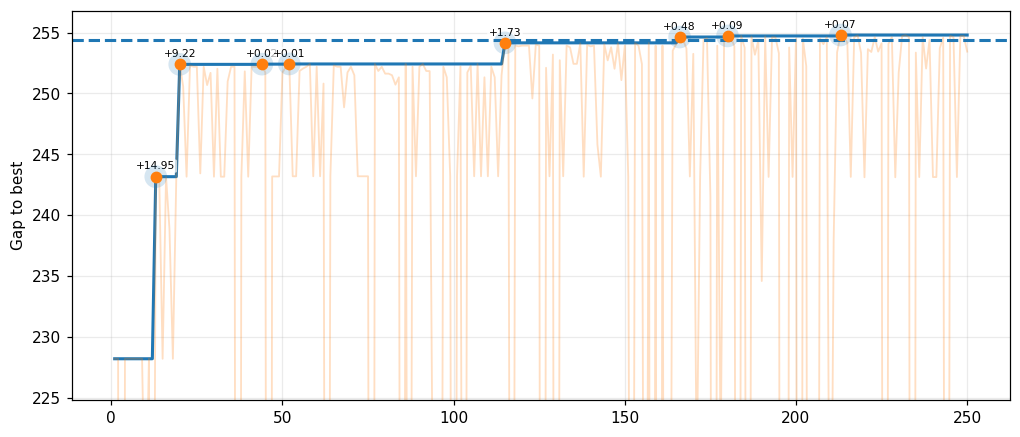

In [11]:
# =========================
# 7) DR CURVE PLOT (single clean plot)
# =========================
import numpy as np
import matplotlib.pyplot as plt

def plot_dr_curve_with_improvements(
    df_dr,
    exact_score=None,
    title="DR curve",
    annotate=False,      # set True if you want iteration numbers on the dots
    max_annotations=25,  # limit labels so it doesn't get unreadable
):
    """
    Plots the full DR curve (no smoothing, no skipping) and highlights *every* best-so-far improvement.
    Requires df_dr columns: ["iteration", "score", "best"].
    """

    df = df_dr.copy()

    # Ensure sorted by iteration and numeric
    df = df.sort_values("iteration").reset_index(drop=True)
    it = df["iteration"].to_numpy()
    cur = df["score"].to_numpy()
    best = df["best"].to_numpy()

    # Identify improvement points (best strictly increases vs previous)
    best_prev = np.r_[np.nan, best[:-1]]
    is_impr = best > best_prev
    impr_idx = np.where(is_impr)[0]
    

    fig, ax = plt.subplots(figsize=(11, 4.6))


    
    # Full curves (all iterations)
    ax.plot(it, best, label="Best-so-far", linewidth=2.0)
    ax.plot(it, cur,  label="Current", alpha=0.25, linewidth=1.2)

    # Exact incumbent line (if provided)
    if exact_score is not None:
        ax.axhline(float(exact_score), linestyle="--", linewidth=2.0,
                   label=f"Exact incumbent = {float(exact_score):.2f}")

    top = np.nanmax(best)
    bottom = max(0.0, top - 30.0)   # 🔁 change 30 → 15 for more zoom
    ax.set_ylim(bottom, top + 2.0)

    
    # Mark improvement points
    best_prev = np.r_[np.nan, best[:-1]]
    delta = best - best_prev
    impr_idx = np.where(delta > 1e-9)[0]

    if len(impr_idx) > 0:
        # "Flash" effect: draw a bigger marker under the dot (glow)
        ax.scatter(it[impr_idx], best[impr_idx],
                   s=220, alpha=0.18, zorder=4, edgecolors="none",
                   label="_glow")  # hidden from legend
        ax.scatter(it[impr_idx], best[impr_idx],
                   s=45, zorder=5, label="Improvements")

        # Label each dot with the improvement size Δ
        for k in impr_idx:
            ax.annotate(
                f"+{delta[k]:.2f}",
                (it[k], best[k]),
                textcoords="offset points",
                xytext=(0, 5),              # closer to point
                ha="center",
                fontsize=7,                 # 🔽 smaller font
                fontweight="normal",        # 🔽 no bold
                color="black",
                bbox=dict(                  # subtle background for contrast
                    boxstyle="round,pad=0.15",
                    fc="white",
                    ec="none",
                    alpha=0.7
                )
            )

    else:
        print("No improvements found (best never increased).")

    # Also print a clean improvement table (no skipping)
    if len(impr_idx) > 0:
        print(f"Number of improvements: {len(impr_idx)}")
        # table-like print (iteration, prev_best, new_best, delta)
        for k in impr_idx:
            prevb = best_prev[k]
            deltab = best[k] - prevb if np.isfinite(prevb) else np.nan
            print(f"it={int(it[k]):4d}  best_prev={prevb:10.6f}  best={best[k]:10.6f}  delta={deltab:10.6f}")
    else:
        print("No improvements found (best never increased).")

    gap = best - cur
    ax.plot(it, gap, alpha=0.35, linewidth=1.0, label="Best − Current (gap)")
    ax.set_ylabel("Gap to best")

out_dr = run_DR_multi(
    inst=inst,
    policy=policy,
    P_T=P_T,
    Q=Q,
    D=D,
    T=T,
    max_iter=max_iter,
    dr_time_limit=dr_time_limit,
    frac_remove=frac_remove,
    accept_epsilon=accept_epsilon,
    seed=seed,
    max_chargers_per_site=max_chargers_per_site,
    cumulative_install=True,
    adaptive_destroy=adaptive_destroy,
    destroy_modes=destroy_modes,
    update_every=update_every,
    reaction=reaction,
    score_best_w=score_best_w,
    score_improve_w=score_improve_w,
    score_accept_w=score_accept_w,
    reconstruct_trials=reconstruct_trials,
)

# ✅ DEFINE THESE
df_dr    = out_dr["DR_log"]
df_trace = out_dr["DR_trace"]
df_batches = out_dr["DR_batches"]

plot_dr_curve_with_improvements(
    df_dr,
    exact_score=out.get("score_exact", None),
    title=f"DR curve | {inst_tag} | policy={policy}",
    annotate=True,
    max_annotations=30,
)


df_batches = out_dr.get("DR_batches", None)
if df_batches is None or len(df_batches) == 0:
    print("No DR_batches produced (check adaptive_destroy=True and update_every).")
else:
    display(df_batches)






In [ ]:

out_path = r"C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\DR_batches_summary.xlsx"
df_batches.to_excel(out_path, index=False)
print("Saved to:", out_path)


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\asus\\OneDrive\\EV-projects\\evcs-projects\\results\\DR_batches_summary.xlsx'